#### PI7-3: AE & VAE
This notebook contains all the implementation and evaluation of the research performed on autoencoders en variational autoencoders.

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

In [5]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [6]:
class Encoder(nn.Module):
    def __init__(self, z_space: int):
        super().__init__()
        self.z_space = z_space

        # (input)1->64, 64->128, 128->256, 256->z_space
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),

            nn.Conv2d(256, z_space, kernel_size=3, stride=2, padding=0, bias=False)
        )
        

    def forward(self, X: torch.Tensor):
        return self.net(X)

In [7]:
class Decoder(nn.Module):
    def __init__ (self, z_space: int):
        super().__init__()
        self.z_space = z_space

        # z_space->256, 256->128, 128->64, 64->1 
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_space, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)


In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, z_space: int):
        super().__init__()
        self.encode = Encoder(z_space)
        self.decode = Decoder(z_space)

    def forward(self, X: torch.Tensor):
        z = self.encode(X)
        y = self.decode(z)
        
        return z, y

In [9]:
x = torch.randn(64, 1, 32, 32)
generator = AutoEncoder(z_space=20)
y, z = generator(x)
y.shape, z.shape

(torch.Size([64, 20, 1, 1]), torch.Size([64, 1, 32, 32]))

In [10]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(32),
    transforms.ToTensor(),
])

In [11]:
BATCH_SIZE = 32
NUM_WORKERS = 4

In [12]:
train_dir = 'data/cifar10_full/train'
test_dir = 'data/cifar10_full/test'

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
testval_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

X_test_val, y_test_val = zip(*testval_dataset)

X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

splitval = int(0.5 * len(testval_dataset))

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [splitval, splitval])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test-Val dataset size: {len(testval_dataset)}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Train dataset size: 50000
Test-Val dataset size: 10000
X_test shape: torch.Size([5000, 1, 32, 32]), y_test shape: torch.Size([5000])
X_val shape: torch.Size([5000, 1, 32, 32]), y_val shape: torch.Size([5000])


In [13]:
EPOCHS = 20
BATCH_SIZE = 256
LEARNING_RATE = 0.03
LEARNING_RATE_GAMMA = 0.9

Z_DIM = 16

In [14]:
generator = AutoEncoder(z_space=Z_DIM).to(DEVICE)

optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=LEARNING_RATE_GAMMA)
criterion = nn.MSELoss()

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, (images, _) in enumerate(train_loader):
        images = images.to(DEVICE)
        # predict and compute loss
        _, preds = generator(images)
        loss = criterion(preds, images)
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
    
    # update learning rate
    scheduler.step()
    
    train_history.append(torch.mean(torch.tensor(batch_history)))

    with torch.no_grad():
        _, preds = generator(X_val.to(DEVICE))
        loss = criterion(preds, X_val.to(DEVICE))
        val_history.append(loss.item())
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")


# TEST
with torch.no_grad():
    z, preds = generator(X_test.to(DEVICE))
    loss = criterion(preds, X_test.to(DEVICE))
    print(f"test_loss {loss.item()}")

epoch 0, train_loss 0.028091808781027794, val_loss 0.021658804267644882
epoch 1, train_loss 0.02168671041727066, val_loss 0.020766625180840492
epoch 2, train_loss 0.021200131624937057, val_loss 0.02078365534543991
epoch 3, train_loss 0.02093234471976757, val_loss 0.020525308325886726
epoch 4, train_loss 0.020665256306529045, val_loss 0.020386656746268272
epoch 5, train_loss 0.020453384146094322, val_loss 0.02010948210954666
epoch 6, train_loss 0.020279934629797935, val_loss 0.019939720630645752
epoch 7, train_loss 0.02011377178132534, val_loss 0.02011197805404663
epoch 8, train_loss 0.019996488466858864, val_loss 0.0198384877294302
epoch 9, train_loss 0.019872449338436127, val_loss 0.019894231110811234
epoch 10, train_loss 0.019771190360188484, val_loss 0.019846580922603607
epoch 11, train_loss 0.019672034308314323, val_loss 0.01970495469868183
epoch 12, train_loss 0.019564703106880188, val_loss 0.019908450543880463
epoch 13, train_loss 0.019518179818987846, val_loss 0.0198155567049980

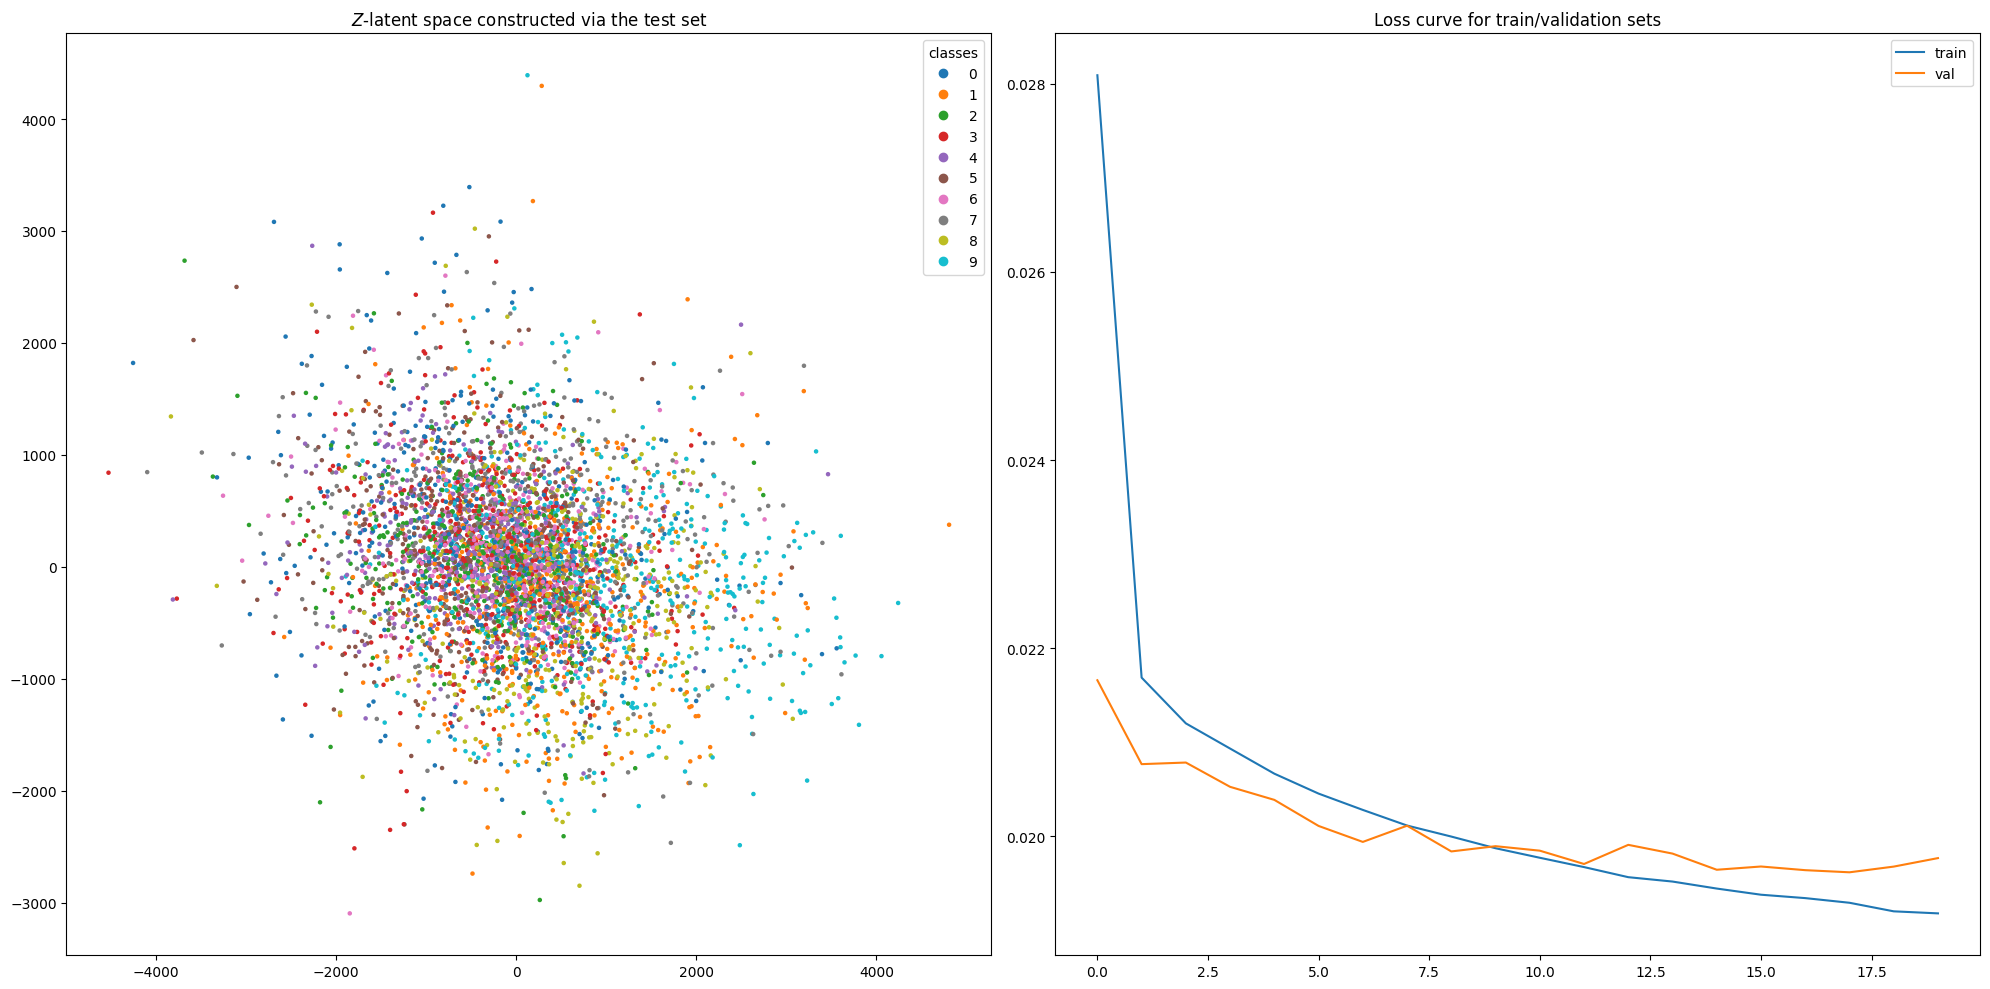

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

z = z.squeeze().cpu().detach()
sc = ax1.scatter(z[:, 0], z[:, 1], c=y_test, s=5, cmap='tab10')
ax1.legend(*sc.legend_elements(), title='classes')
ax1.set_title("$Z$-latent space constructed via the test set")

ax2.plot(train_history, label="train")
ax2.plot(val_history, label="val")
ax2.legend()
ax2.set_title("Loss curve for train/validation sets")

plt.tight_layout()

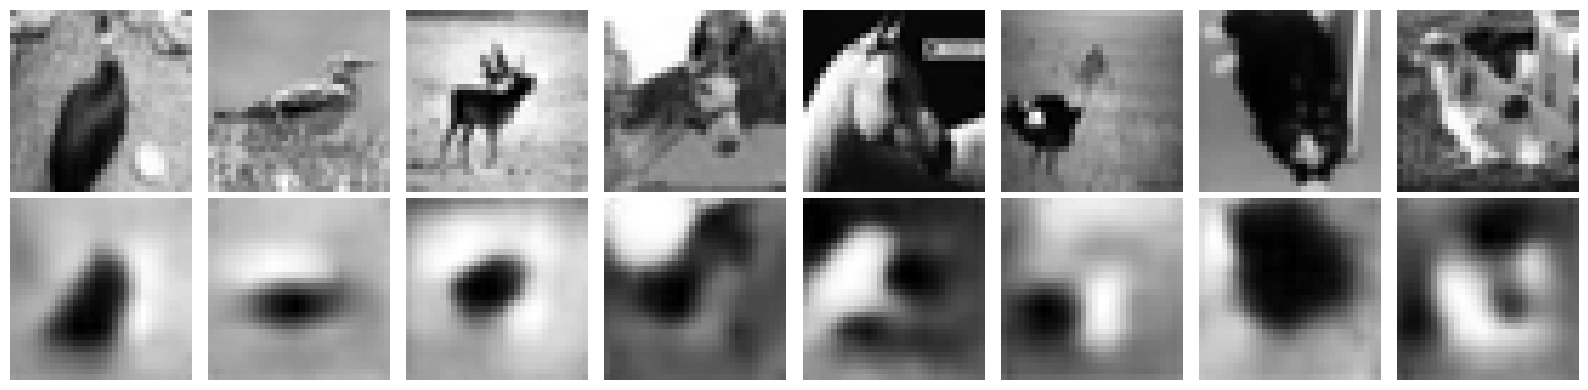

In [16]:
import matplotlib.pyplot as plt

generator.eval()
with torch.no_grad():
    _, recon = generator(X_val[:8].to(DEVICE))

recon = recon.cpu().squeeze().numpy()
original = X_val[:8].squeeze().numpy()

fig, axs = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axs[0, i].imshow(original[i], cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(recon[i], cmap='gray')
    axs[1, i].axis('off')
axs[0, 0].set_ylabel("Original", fontsize=12)
axs[1, 0].set_ylabel("Reconstructed", fontsize=12)
plt.tight_layout()
plt.show()